# Using deep learning to classify Weibull patterns 

## Overview 
1. Min-max scaling helps deal with sample from Weibulls of different scales 
1. Autoencoder can encode to 30 dimensions. We only work with sample of size 31 and above, so this shouldn't represent more dimensions than data points in a sample. Arguably, distribution fitting boils data down to only 2 or 3 parameters, which is not enough to deal with all the complexity in the case where we can't be sure that data is "nearly Weibull". The autoencoder with 30 dimensions can represent the data more richly. 

In [137]:
import numpy as np
import pandas as pd 
from scipy.stats import weibull_min, norm
from enum import Enum, auto
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from umap import UMAP
import seaborn as sns 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data generation

In [138]:
class DistributionCategory(Enum):
    LESS_THAN_ONE = auto()
    EQUAL_TO_ONE = auto()
    GREATER_THAN_ONE = auto()
    OTHER = auto()

In [139]:
np.random.seed(42)
num_samples = 80000
max_obs_per_sample = 1000
data_samples = []
labels = []

In [140]:
for _ in range(num_samples):
    n = np.random.randint(31, max_obs_per_sample + 1)
    category = np.random.choice([DistributionCategory.LESS_THAN_ONE, DistributionCategory.EQUAL_TO_ONE, DistributionCategory.GREATER_THAN_ONE, DistributionCategory.OTHER])
    
    if category == DistributionCategory.LESS_THAN_ONE:
        shape = np.random.uniform(0.1, 0.99)
        scale = np.random.uniform(100, 10000)
        sample = weibull_min.rvs(c=shape, scale=scale, size=n)
        
    elif category == DistributionCategory.EQUAL_TO_ONE:
        shape = 1.0
        scale = np.random.uniform(100, 10000)
        sample = weibull_min.rvs(c=shape, scale=scale, size=n)
        
    elif category == DistributionCategory.GREATER_THAN_ONE:
        shape = np.random.uniform(1.01, 10.0)
        scale = np.random.uniform(100, 10000)
        sample = weibull_min.rvs(c=shape, scale=scale, size=n)
        
    else:
        # Uniform distribution
        if np.random.random() < 0.5:
            low = np.random.uniform(0, 0)
            high = np.random.uniform(100, 10000)
            sample = np.random.uniform(low, high, size=n)
        # Bimodal distribution
        else:
            mean1 = np.random.uniform(-50, -25)
            mean2 = np.random.uniform(25, 50)
            std1 = np.random.uniform(1, 10)
            std2 = np.random.uniform(1, 10)
            dist1 = norm(loc=mean1, scale=std1)
            dist2 = norm(loc=mean2, scale=std2)
            sample = np.concatenate([dist1.rvs(size=n//2), dist2.rvs(size=n//2)])
            np.random.shuffle(sample)
    
    data_samples.append(sample)
    labels.append(category)

In [141]:
# min-max scaling and padding the data: 
data_samples_min_max_scaled = [(sample - sample.min()) / (sample.max() - sample.min()) for sample in data_samples]
data_samples_preprocessed = [np.pad(sample, (0, max_obs_per_sample - len(sample))) for sample in data_samples_min_max_scaled]

In [142]:
labels = pd.Series(labels)

In [143]:
labels.head()

0            DistributionCategory.OTHER
1    DistributionCategory.LESS_THAN_ONE
2     DistributionCategory.EQUAL_TO_ONE
3    DistributionCategory.LESS_THAN_ONE
4    DistributionCategory.LESS_THAN_ONE
dtype: object

In [144]:
labels.value_counts()

DistributionCategory.LESS_THAN_ONE       20161
DistributionCategory.OTHER               20066
DistributionCategory.GREATER_THAN_ONE    19914
DistributionCategory.EQUAL_TO_ONE        19859
dtype: int64

10648


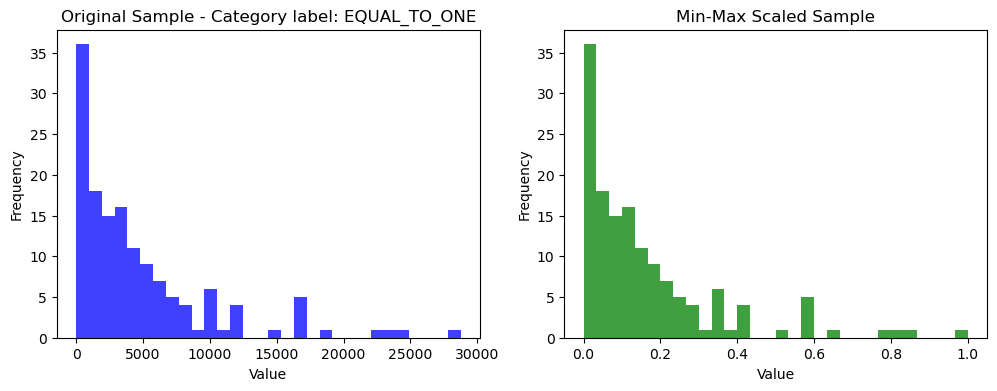

In [145]:
# Select a single sample from the data_samples list
sample_index = np.random.randint(len(labels) + 1, size=1).tolist()[0]
print(sample_index)

sample = data_samples[sample_index]
label = labels[sample_index]

# Apply min-max scaling to the selected sample
sample_min_max_scaled = data_samples_min_max_scaled[sample_index]

# Plot the histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(sample, bins=30, alpha=0.75, color='blue')
ax1.set_title(f'Original Sample - Category label: {label.name}')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')

ax2.hist(sample_min_max_scaled, bins=30, alpha=0.75, color='green')
ax2.set_title('Min-Max Scaled Sample')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')

plt.show()


## Train/test split 

In [147]:
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(data_samples_preprocessed, labels, test_size=0.2, random_state=42)

## Autoencoder architecture

In [148]:
input_size = max_obs_per_sample
embedding_size = 30

class Autoencoder(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, embedding_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(input_size, embedding_size)

In [149]:
autoencoder

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=30, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1000, bias=True)
    (5): ReLU()
  )
)

## Autoencoder training 

In [150]:
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=0.2, random_state=42)

# Convert Enum labels to integers
y_train_int = [label.value for label in y_train]
y_val_int = [label.value for label in y_val]

# Convert data to PyTorch tensors
y_train_tensor = torch.tensor(y_train_int, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_int, dtype=torch.long)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

In [155]:
# Training parameters
epochs = 300
batch_size = 256
learning_rate = 0.001
patience = 10 

autoencoder = Autoencoder(input_size, embedding_size).to(device)

# Set loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Initialize variables for early stopping
best_val_loss = float('inf')
epochs_without_improvement = 0

# Train the autoencoder
autoencoder.train()
for epoch in range(epochs):
    for batch_idx in range(0, len(X_train_tensor), batch_size):
        batch = X_train_tensor[batch_idx:batch_idx+batch_size].to(device)
        optimizer.zero_grad()
        outputs = autoencoder(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        
    # Calculate validation loss
    autoencoder.eval()
    val_outputs = autoencoder(X_val_tensor.to(device))
    val_loss = criterion(val_outputs.to(device), X_val_tensor.to(device))

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Print progress
    if (epoch + 1) % 10 == 0 or epochs_without_improvement == 1:
        print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    # Stop training if no improvement for 'patience' epochs
    if epochs_without_improvement >= patience:
        print(f'Early stopping triggered at epoch {epoch + 1}.')
        break

Epoch [10/300], Training Loss: 0.0310, Validation Loss: 0.0295
Epoch [20/300], Training Loss: 0.0296, Validation Loss: 0.0282
Epoch [24/300], Training Loss: 0.0293, Validation Loss: 0.0280
Epoch [30/300], Training Loss: 0.0288, Validation Loss: 0.0275
Epoch [38/300], Training Loss: 0.0279, Validation Loss: 0.0267
Epoch [40/300], Training Loss: 0.0278, Validation Loss: 0.0266
Epoch [47/300], Training Loss: 0.0276, Validation Loss: 0.0265
Epoch [50/300], Training Loss: 0.0275, Validation Loss: 0.0264
Epoch [53/300], Training Loss: 0.0275, Validation Loss: 0.0263
Epoch [60/300], Training Loss: 0.0272, Validation Loss: 0.0260
Epoch [66/300], Training Loss: 0.0270, Validation Loss: 0.0259
Epoch [68/300], Training Loss: 0.0270, Validation Loss: 0.0259
Epoch [70/300], Training Loss: 0.0270, Validation Loss: 0.0259
Epoch [75/300], Training Loss: 0.0269, Validation Loss: 0.0258
Epoch [80/300], Training Loss: 0.0269, Validation Loss: 0.0258
Epoch [82/300], Training Loss: 0.0268, Validation Loss:

## Autoencoder inference 

In [156]:
if autoencoder.training: 
    autoencoder.eval()
    
with torch.no_grad(): 
    out = autoencoder.encoder(X_train_tensor.to(device))

In [157]:
out.shape

torch.Size([51200, 30])

In [159]:
mapper = UMAP(n_components=2, metric='cosine', random_state=2023).fit(out.cpu())

df_umap_2d = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_umap_2d['label'] = [enum.name for enum in y_train]
df_umap_2d

,X,Y,label
0,-2.133142,13.308155,EQUAL_TO_ONE
1,11.691412,1.817380,GREATER_THAN_ONE
2,0.585110,-0.105859,GREATER_THAN_ONE
3,1.369874,11.253904,LESS_THAN_ONE
4,-4.651693,10.357920,EQUAL_TO_ONE
...,...,...,...
51195,-4.063727,11.569068,OTHER
51196,2.601778,-1.339338,LESS_THAN_ONE
51197,-3.912632,11.793769,OTHER
51198,-4.679669,4.712748,GREATER_THAN_ONE


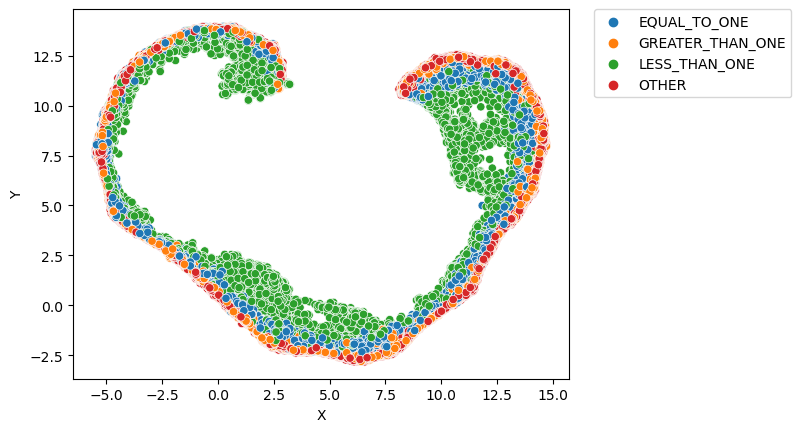

In [160]:
sns.scatterplot(data=df_umap_2d, x='X', y='Y', hue='label')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

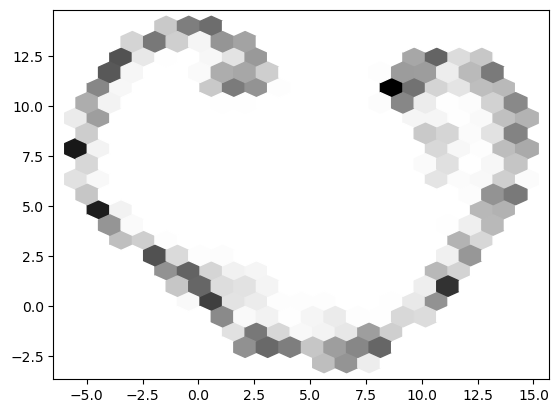

In [161]:
fig, ax = plt.subplots()
ax.hexbin(
    df_umap_2d['X'],
    df_umap_2d['Y'],
    cmap="Greys", 
    gridsize=20
)
fig.show()

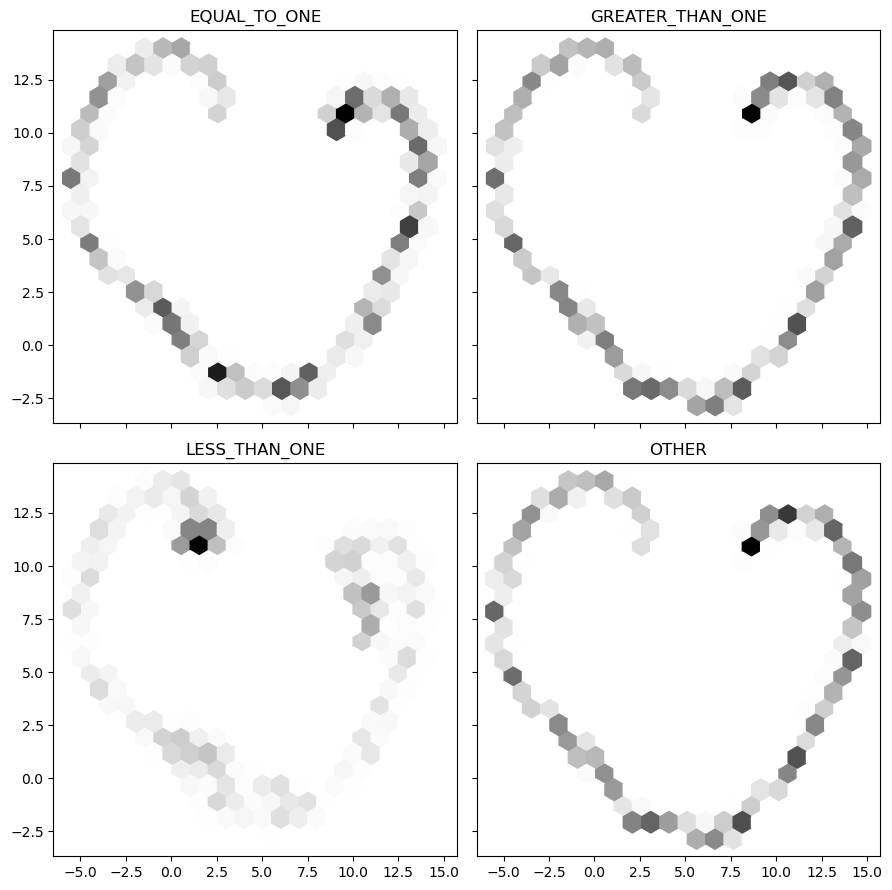

In [162]:
fig, axes = plt.subplots(2, 2, figsize=(9,9), sharex=True, sharey=True)
axes = axes.flatten()
labels = df_umap_2d['label'].unique()
cmap = "Greys"

for i, label in enumerate(labels): 
    df_umap_sub = df_umap_2d.query('label==@label')
    axes[i].hexbin(
        df_umap_sub['X'], 
        df_umap_sub['Y'], 
        cmap=cmap, 
        gridsize=20
    )
    axes[i].set_title(label)
plt.tight_layout()
plt.show()
